![](https://i.imgur.com/LZB5LEa.png)

# Introduction

### Why are we doing this?
Music. Experts have been trying for a long time to understand sound and what differenciates one song from another. How to visualize sound. What makes a tone different from another.

In this notebook we will go through an in depth analysis of sound and how we can **visualize, classify and ultimately understand** it.

### The data:
* **genres original** - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
* **images original** - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible (we'll be talking about this more in depth later)
* **2 CSV files** - Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file (more in depth later). The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). *With data, more is always better*.

### Purpose:
1. We want to understand **what is an Audio file**. What features we can visualize on this kind of data.
2. **EDA**. ALways good, here very necessary.
3. **Genres Classification** on the 3 seconds CSV file (trying multiple models and identify which has the best accuracy)
4. A **recommender system**: given a song, give me top X songs most similar.

### Credits and Acknowledgements:
* This was a team project for uni, so the effort in creating this wasn't only my own. So, I want to thank **James Wiltshire, Lauren O'Hare and Minyu Lei** for being the best teammates ever and for having so much fun and learning so much during the 3 days we worked on this.
* You can do a lot of documentation online, but an article that helped us a lot in doing this was [Parul Pandey's](https://www.kaggle.com/parulpandey) notebook for [Music Genre Classification with Python](https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8)

In [1]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
general_path = '../input/gtzan-dataset-music-genre-classification/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


# Explore Audio Data

We will use `librosa`, which is the mother of audio files.

## Understanding Audio
Let's first Explore our Audio Data to see how it looks (we'll work with `reggae.00036.wav` file).

* **Sound**: sequence of vibrations in varying pressure strengths (`y`)
* The **sample rate** (`sr`) is the number of samples of audio carried per second, measured in Hz or kHz

In [3]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [4]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


### 2D Representation: Sound Waves

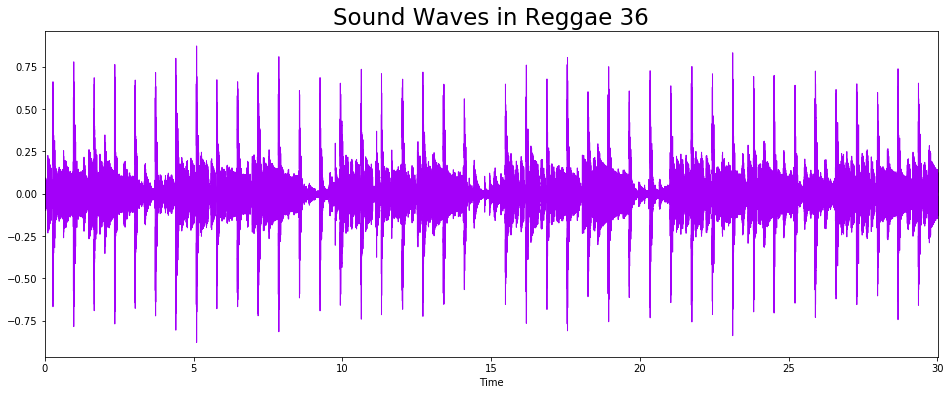

In [5]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

### Fourier Transform

* Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
* Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.

In [6]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


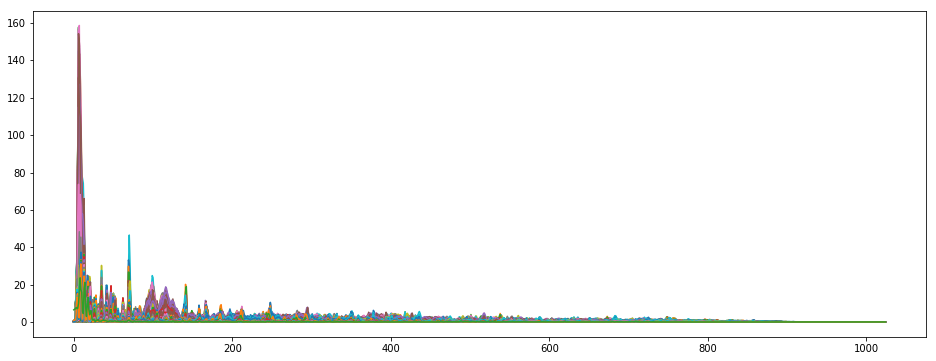

In [7]:
plt.figure(figsize = (16, 6))
plt.plot(D);

### The Spectrogram

* What is a spectrogram? A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams ([wiki](https://en.wikipedia.org/wiki/Spectrogram)).
* Here we convert the frequency axis to a logarithmic one.

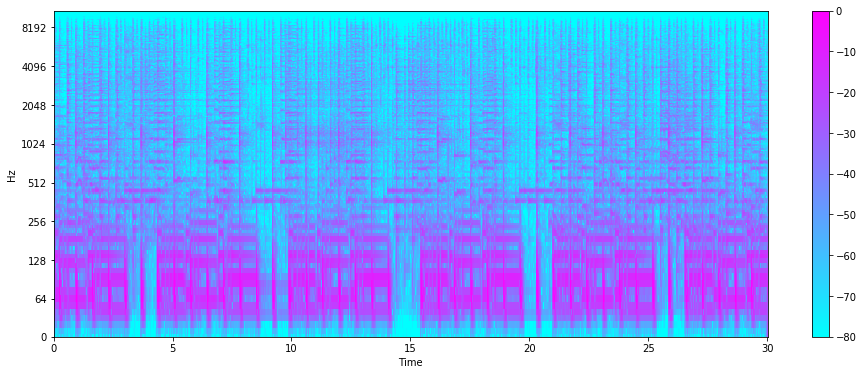

In [8]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

### Mel Spectrogram

* The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram, but with a Mel Scale on the y axis.

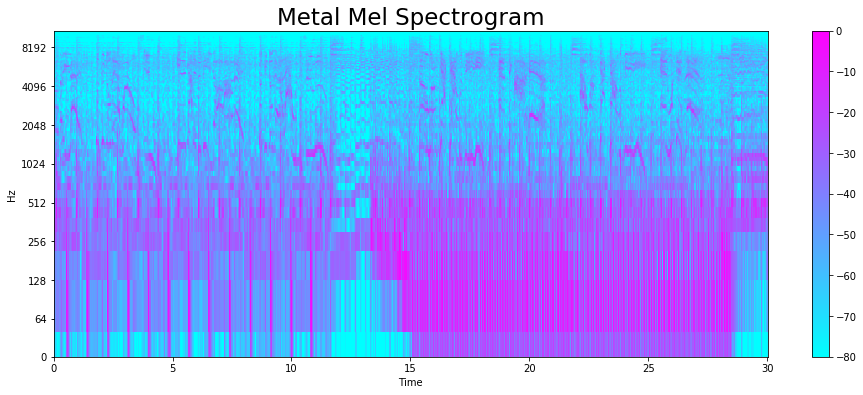

In [9]:
y, sr = librosa.load(f'{general_path}/genres_original/metal/metal.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

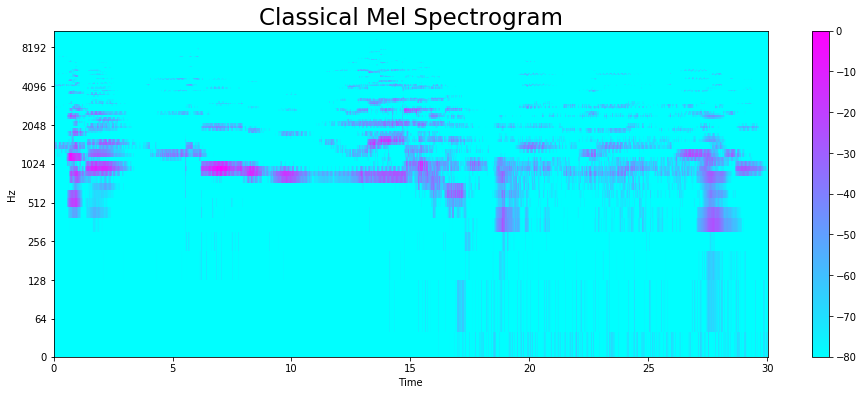

In [10]:
y, sr = librosa.load(f'{general_path}/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Classical Mel Spectrogram", fontsize = 23);

## Audio Features

### Zero Crossing Rate

* the rate at which the signal changes from positive to negative or back.

In [11]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

39232


### Harmonics and Perceptrual

* Harmonics are characteristichs that human years can't distinguish (represents the sound color)
* Perceptrual understanding shock wave represents the sound rhythm and emotion

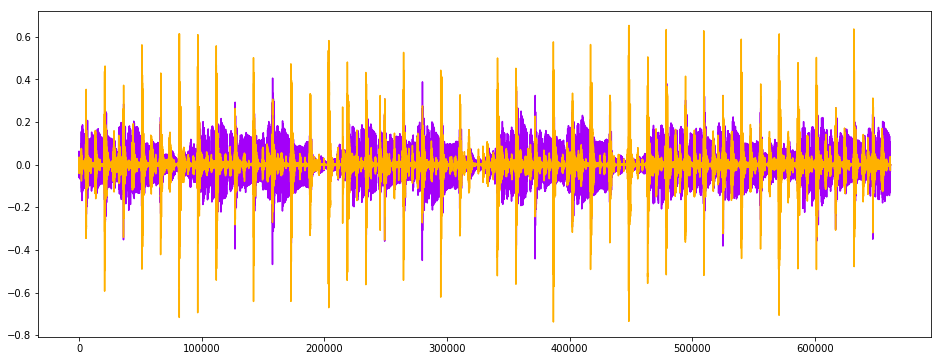

In [12]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

### Tempo BMP (beats per minute)

Dynamic programming beat tracker.

In [13]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

107.666015625

### Spectral Centroid

* indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [14]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1817.93364736 1953.08392985 2038.8113414  ...  766.50416352 1019.33192639
 1081.69931747] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


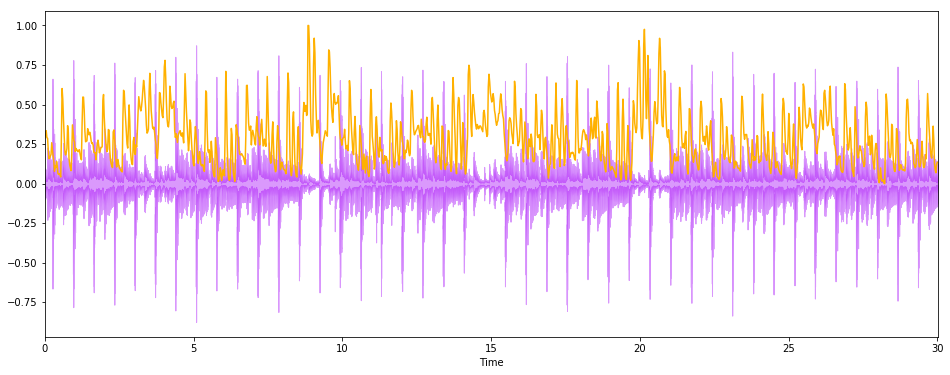

In [15]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

### Spectral Rolloff
* is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

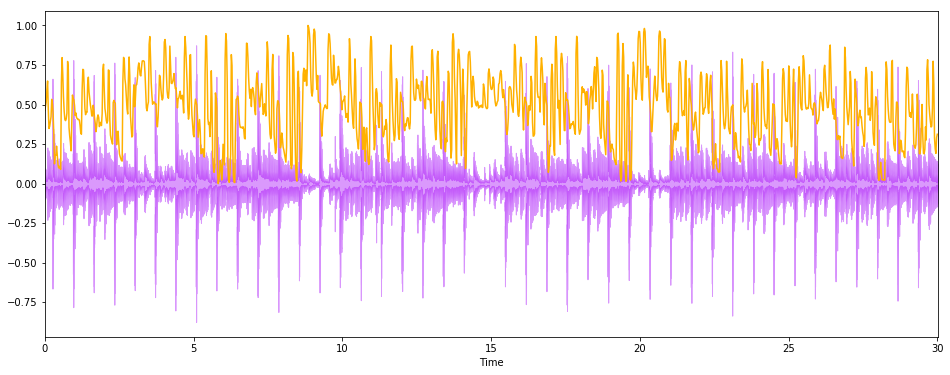

In [16]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

### Mel-Frequency Cepstral Coefficients:

* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 1293)


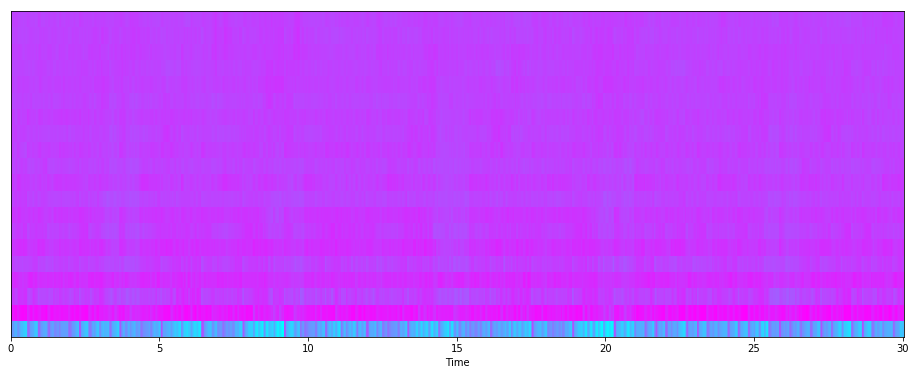

In [17]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Data needs to be scaled:

Mean: 3.6878356e-10 

Var: 1.0000001


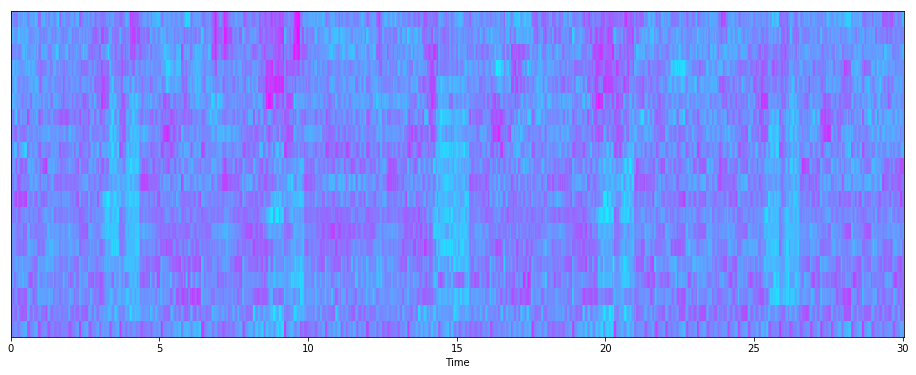

In [18]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

### Chroma Frequencies

* Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

Chromogram shape: (12, 133)


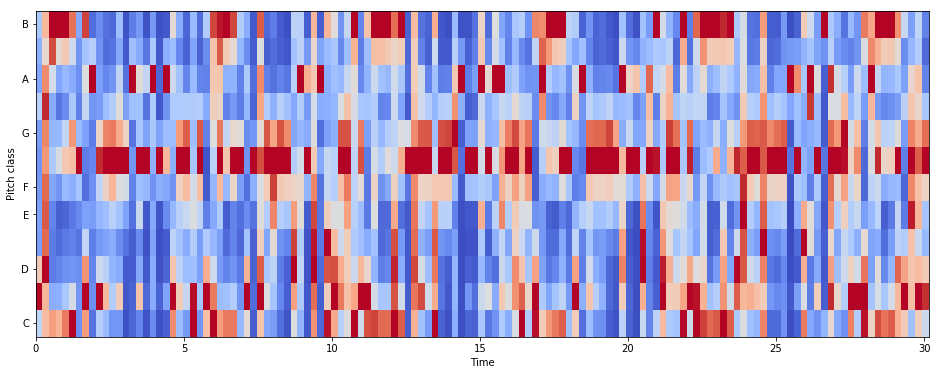

In [19]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

## EDA

EDA is going to be performed on the `features_30_sec.csv`. This file contains the mean and variance for each audio file fo the features analysed above. 

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [20]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [1]:
data.columns

NameError: name 'data' is not defined

### Correlation Heatmap for feature means

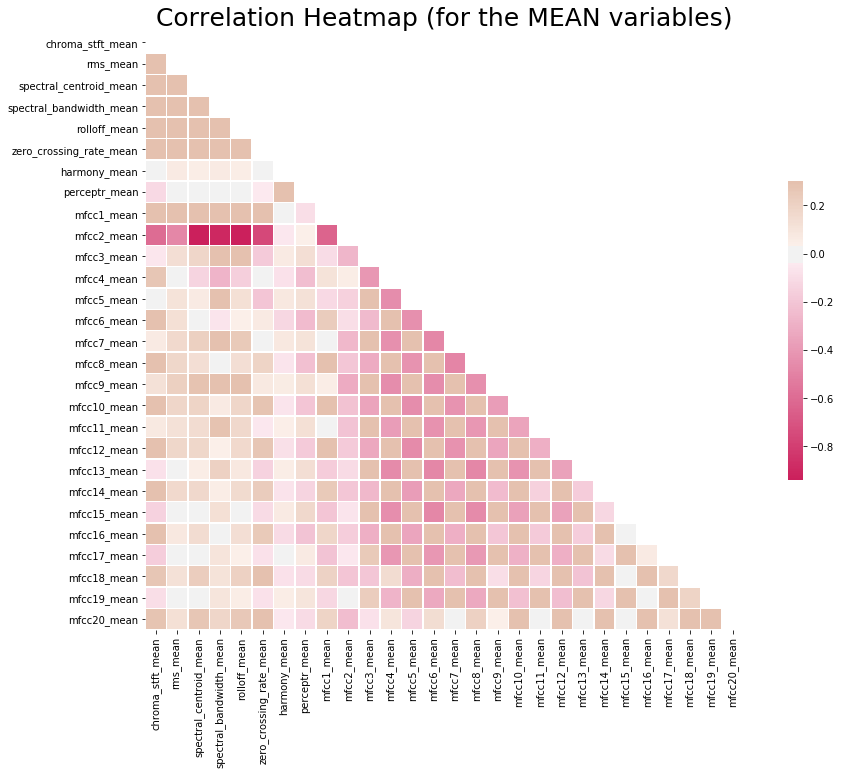

In [21]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

### Box Plot for Genres Distributions

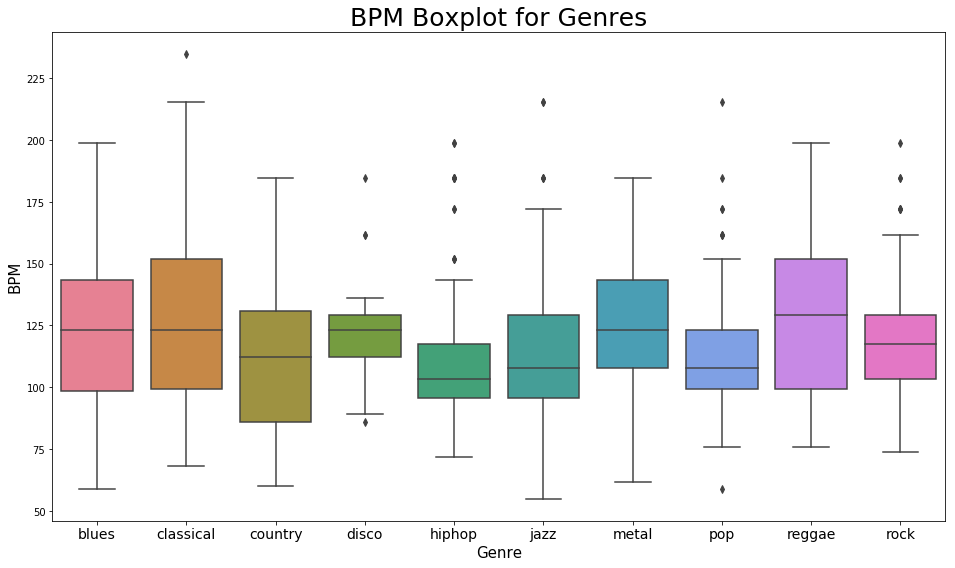

In [22]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

### Principal Component Analysis - to visualize possible groups of genres

1. Normalization
2. PCA
3. The Scatter Plot

In [23]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.2439355 , 0.21781804])

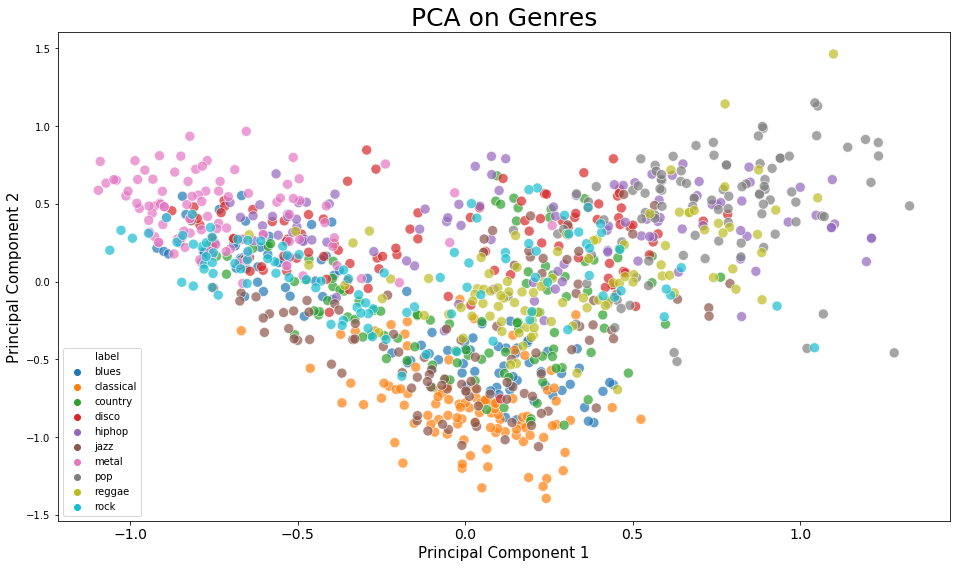

In [24]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

# Machine Learning Classification

Using the `features_3_sec.csv` file, we can try to build a classifier that accurately predicts for any new audio file input it's genre.

### Libraries

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

### Reading in the Data

Now let's try to predict the Genre of the audio using Machine Learning techniques.

In [26]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### Features and Target variable

* creates the target and feature variables
* normalizes the data

In [27]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

### Splitting the data into training and testing

* 70% - 30% split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creating a Predefined function to assess the accuracy of a model

* input is the model
* fits the model on the training dataset
* predicts on the testing features
* compares the predictions with the actuals

In [29]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

### Trying 10 different models to assess their performance

We tried 10 classification models, the best performing model was XGBooster.

In [30]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")


# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.51952 

Accuracy Stochastic Gradient Descent : 0.65532 

Accuracy KNN : 0.80581 

Accuracy Decission trees : 0.64298 

Accuracy Random Forest : 0.81415 

Accuracy Support Vector Machine : 0.75409 

Accuracy Logistic Regression : 0.6977 

Accuracy Neural Nets : 0.67734 

Accuracy Cross Gradient Booster : 0.90224 

Accuracy Cross Gradient Booster (Random Forest) : 0.74875 



In [31]:
import joblib
joblib.dump(xgb, "xgb_model.pkl")

['xgb_model.pkl']

### XGBoost is the winner - 90% accuracy

* create the final model
* compute confusion matrix
* Compute Feature Importance

Accuracy : 0.90224 



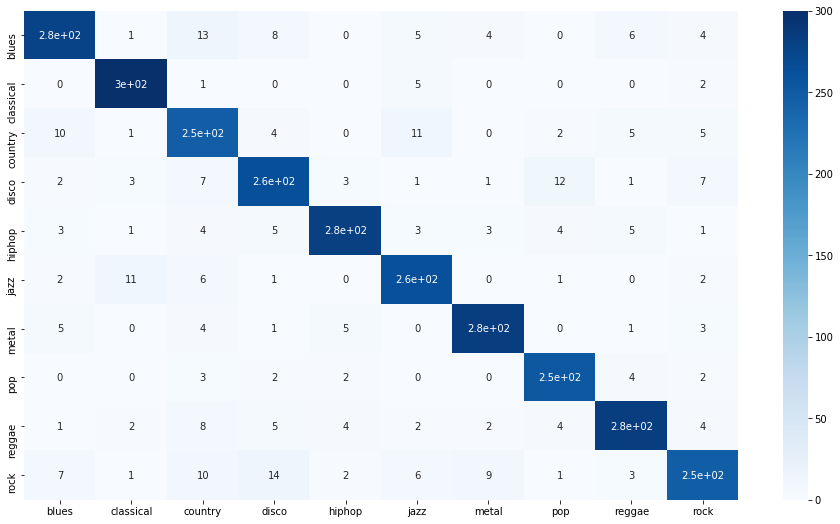

In [32]:
# Final model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

### Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

Using TensorFlow backend.


# Recommender Systems

"Recomender" Systems enable us for any given vector to find the best similarity, ranked in descending order, from the bast match to the least best match. 

For Audio files, this will be done through `cosine_similarity` library.

In [ ]:
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

### Cosine similarity

Calculates the *pairwise cosine similarity* for each combination of songs in the data. This results in a 1000 x 1000 matrix (with redundancy in the information as item A similarity to item B == item B similarity to item A).

In [ ]:
# Cosine similarity
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

### Song similarity scoring

`find_similar_songs()` - is a predefined function that takes the name of the song and returns top 5 best matches for that song.

In [ ]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

### Putting the Similarity Function into Action:

### POP Example

In [ ]:
# pop.00019 - Britney Spears "Hit me baby one more time"
find_similar_songs('pop.00019.wav') 

ipd.Audio(f'{general_path}/genres_original/pop/pop.00019.wav')

### Similar song match no.1 
*Britney Spears* - **I'm so curious (2009 remaster)**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00023.wav')

### Similar song match no.2
*Britney Spears* - **Sometimes**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00034.wav')

### Similar song match no.3
*Jennifer Lopez* - **Play**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00078.wav')

### Similar song match no.4
*Mandy Moore* - **Candy**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00088.wav')

### Similar song match no.5
*Mandy Moore* - **Everything my heart desires**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/pop/pop.00091.wav')

### METAL Example

In [ ]:
# metal.00002 - Iron Maiden "Flight of Icarus"
find_similar_songs('metal.00002.wav') 

ipd.Audio(f'{general_path}/genres_original/metal/metal.00002.wav')

### Similar song match no.1 
*Motorhead* - **Ace of Spades**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/metal/metal.00028.wav')

### Similar song match no.2
*Queen* - **Tear it Up**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/metal/metal.00059.wav')

### Similar song match no.3
*Queen* - **Another One Bites The Dust**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/rock/rock.00018.wav')

### Similar song match no.4
*Queen* - **Under Pressure**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/rock/rock.00017.wav')

### Similar song match no.5
*Queen* - **Tie Your Mother Down**

In [ ]:
ipd.Audio(f'{general_path}/genres_original/rock/rock.00016.wav')

<div class="alert alert-block alert-info">
<p>If you liked this, don't be shy, upvote! 😁<p>

<b>Toodles!<b>
</div>